Document for Model training



Importing packages

In [1]:
import matplotlib.pyplot as plt
#from SynDataFunctionality.TreeLib import Tree, gen_tree
import numpy as np
#from SynDataFunctionality.genInputFromLabel import labelToInput
import torch.utils.data as td
import torchvision


c:\Users\nugni\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] Den angivne procedure blev ikke fundet
  warn(f"Failed to load image Python extension: {e}")


Setting Constants

In [2]:
startX = 5
startY = 360
startAngle = 0
starWidth = 20
stopWidth = 2
startLength = 20
bifurcProb = 0.3 #should be changed to prop dist dependent on number of 'straigt' lines

train_val_test_split_probs = [0.25, 0.25, 0.5]

Make some trees 

In [3]:
from SynDataFunctionality.saveSynData import gen_syn_data
import torch.utils.data as td
from DataSets import SynData

Make and save some synthetic data

In [4]:
lst = [startX, startY, starWidth, startLength, startAngle, stopWidth, 0.3]
num = 4

# make num samples
gen_syn_data("SynData/SynInput", "SynData/SynLabel", lst, (736, 736), num)


Make our dataSet and it outputs data as expected

In [5]:
from torchvision.transforms import Resize
import torchvision

SynDataSet = SynData("SynData/synInput", "SynData/synLabel")
SynDataSetWRepeat = SynData("SynData/synInput", "SynData/synLabel", repeat_channels=True)

#Test we can retrieve data from Dataset
test, lab = SynDataSet[0]
print(test.shape)
print(lab.shape)


torch.Size([1, 736, 736])
torch.Size([1, 736, 736])


Make, train, validation and test data set of synthetic data

In [6]:
SynTrainData, SynValData, SynTestData = td.random_split(SynDataSet, train_val_test_split_probs)

Visualize synthetic generated data

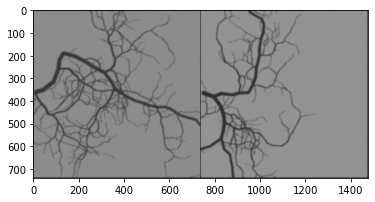

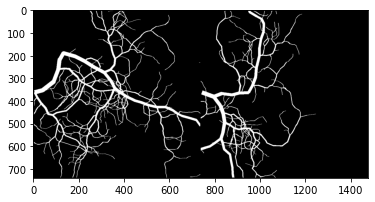

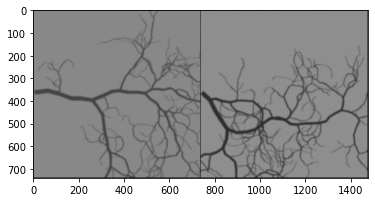

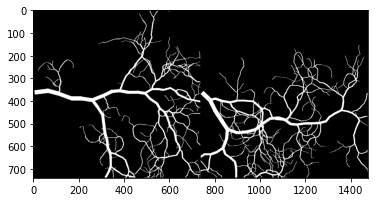

In [7]:
import torchvision

#test that dataloader works, and show images
test_loader = td.DataLoader(SynDataSet, batch_size=2, shuffle=True)

testIter = iter(test_loader)
for i in range(min(len(testIter), 4)):
    imgs, labs = next(testIter)
    grid = torchvision.utils.make_grid(imgs) #.numpy()[0] hack to show tensor in plt
    plt.imshow(grid.numpy()[0], cmap="gray", vmin=0, vmax=255)
    plt.show()
    lab_grid = torchvision.utils.make_grid(labs)
    plt.imshow(lab_grid.numpy()[0], cmap="gray", vmin=0, vmax=1)
    plt.show()

In [8]:
#Test transformations work correctly on dataloader:
#from torchvision.transforms import RandomVerticalFlip, RandomHorizontalFlip, Resize, CenterCrop, Normalize
#from torchvision.transforms.functional import rotate
#import torchvision

#t_both = [RandomHorizontalFlip(p=0.5),  RandomVerticalFlip(p=0.5)]
#Maybe normalize imgs automatically in dataSet

In [9]:
#TransDataSet = SynData("SynData/synInput", "SynData/synLabel", transforms_both=t_both, repeat_channels=True)

Experiment with Basic Unet (to test whether it works)

Import packages and files for Unet and training

In [10]:
from Unet.UNetBasic import UnetBasic
import torch
import torch.optim as optim
import torch.nn as nn
import torch.cuda


In [11]:
#make Unet

net1 = UnetBasic()

#Try to use cuda machine

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#check which device we are on

print(device)


cpu


Make training and validation data

In [12]:
trainLoader = td.DataLoader(SynTrainData, shuffle=True)
valLoader = td.DataLoader(SynValData, shuffle=True)

Pretraining our basic Unet

In [13]:
from trainingFunctionality import trainLoop

net1.to(device) #For now is cpu, but will hopefully be CUDA later
net1 = net1.float() #hack that should remove float error

#Adam for now
optimizer = optim.Adam(net1.parameters(), lr=0.001)
criterion = nn.BCELoss()
criterion.to(device)
epochs = 2

#Training, pray for me. Idea; only print av. epoch error. Decide later
trainLoss, testLoss, net = trainLoop(net1, optimizer, criterion, device, epochs, trainLoader, valLoader, print_interv=1)

[1,     1] loss: 0.681
[2,     1] loss: 0.571
Finished training! :^)


Save model, such that we do not need to retrain

In [14]:
#save model
modelPath = "savedModels/"
UnetName = "FirstUnet"

#save model
torch.save(net.state_dict(), (modelPath + UnetName))

#Create unet
unetBasic = UnetBasic().to(device)
#load trained model's parameters into unet
unetBasic.load_state_dict(torch.load((modelPath + UnetName)))

<All keys matched successfully>

Visualize loss of Unet Training

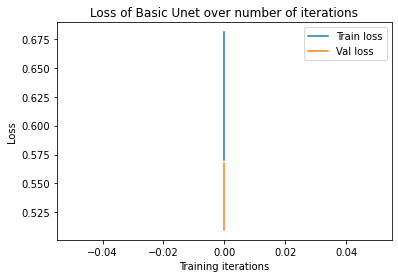

In [15]:
from trainingFunctionality import visualizeLoss #need to fix
visualizeLoss("Basic Unet", 0, trainLoss, testLoss)
#visualizeLoss("Basic Unet", 5, trainLoss[100:], testLoss[100:]) #something funky going on. Why does it stop at 1000 and not 1300??

Test Unet

In [18]:
from trainingFunctionality import test_net

testLoader = td.DataLoader(SynTestData, shuffle=True)

test_net(unetBasic, testLoader, device, illustrate=False)

f1 score: 0.76806

f1 score: 0.76373

Mean f1 score: 0.76590


Train SegFormer.

First; get model

In [19]:
from transformers import SegformerForSemanticSegmentation

Define model

In [22]:
#https://keras.io/examples/vision/segformer/
#https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/model#transformers.PreTrainedModel.from_pretrained
model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
segModel = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,       #Binær klassifikation
    ignore_mismatched_sizes=True, #do not raise an error if some of the weights from the checkpoint do not have the same size as the weights of the model
    reshape_last_stage=True #https://huggingface.co/transformers/v4.12.5/model_doc/segformer.html
    )

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Freeze all paramters instead of those in decoder for now. I.e. only train on decoder.

In [23]:
#Freeze parameters in entire model
for param in segModel.parameters():
    param.requires_grad = False

#Unfreeze decoder's åarameters
for param in model.decode_head.parameters():
    param.requires_grad = True


Export model to device, and define optimizer

In [28]:
from transformers import AdamW
from tqdm import tqdm

epochs = 2

segModel.to(device)

optimizer = AdamW(model.parameters(), lr=0.00006) #model.parameters skal måske ændres??

criterion = nn.BCELoss()
criterion.to(device)

c:\Users\nugni\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BCELoss()

In [43]:
SynTrainDataR, SynValDataR, SynTestDataR = td.random_split(SynDataSetWRepeat, [0.5, 0.25, 0.25])

In [44]:
trainLoaderR, valLoaderR, testLoaderR = td.DataLoader(SynTrainDataR, batch_size=1), td.DataLoader(SynValDataR, batch_size=1), td.DataLoader(SynTestDataR, batch_size=1)

Train the model. Dobble check that we train the parameters we think we train
https://stackoverflow.com/questions/70256003/how-can-i-only-train-the-classifier-and-freeze-rest-of-the-parameters-in-pytorch

In [56]:
losses = []
val_losses = []
for epoch in range(1, epochs+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(trainLoaderR)
    accuracies = []
    run_losses = []
    val_accuracies = []
    run_val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values, labels = batch

        #transfer data to device, e.g. GPU
        pixel_values, labels = pixel_values.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values.float(), labels=labels[:,0,:, :].long()) #Should not do anything bad

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        #mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted.detach().cpu().numpy()
        true_labels = labels.detach().cpu().numpy()
        #accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        #accuracies.append(accuracy)
        run_losses.append(loss.item())
        #pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch2 in enumerate(valLoaderR):
                pixel_values, labels = batch2

                #transfer data to device, e.g. GPU
                pixel_values, labels = pixel_values.to(device), labels.to(device)

                outputs2 = model(pixel_values=pixel_values.float(), labels=labels[:,0,:, :].long())
                upsampled_logits = nn.functional.interpolate(outputs2.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                #mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted.detach().cpu().numpy()
                true_labels = labels.detach().cpu().numpy()
                #accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs2.loss
                #val_accuracies.append(accuracy)
                run_val_losses.append(val_loss.item())
    losses.append(sum(run_losses)/len(run_losses))
    val_losses.append(sum(run_val_losses)/len(run_val_losses))
    print(f"Train Loss: {losses[epoch-1]}\
         Val Loss: {val_losses[epoch-1]}") #Tog 10 min før
    #print(f"Train Loss: {sum(losses)/len(losses)}\
    #     Val Loss: {sum(val_losses)/len(val_losses)}") #Tog 10 min før

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 0.6991284489631653         Val Loss: 0.7219802439212799
Epoch: 2


100%|██████████| 1/1 [00:19<00:00, 19.89s/it]


Train Loss: 0.690467119216919         Val Loss: 0.7229881584644318


In [51]:
print(len(trainLoaderR))
print(val_losses)

2
[0.7198137044906616, 0.7009400725364685]


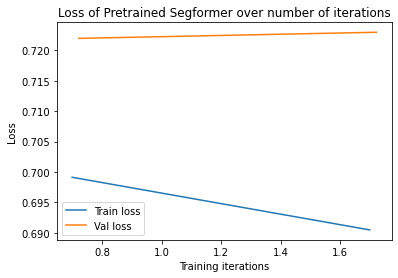

In [57]:
visualizeLoss("Pretrained Segformer", 1, losses, val_losses)

Visualize results on test set

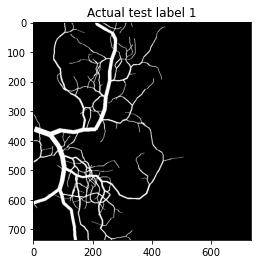

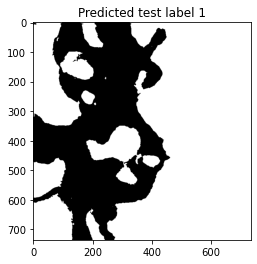

In [58]:
for idx, batch2 in enumerate(testLoaderR):
    img, lab = batch2
    outputs = segModel(pixel_values=img.to(device).float())
    upsampled_logits = nn.functional.interpolate(outputs.logits, size=lab.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)

    plt.imshow(lab[0][0].numpy(), cmap="gray")
    plt.title("Actual test label {0}".format(idx+1))
    plt.show()
    plt.imshow(predicted[0].cpu().numpy(), cmap="gray")
    plt.title("Predicted test label {0}".format(idx+1))
    plt.show()

In [35]:
#save model
modelPath = "savedModels/"
UnetName = "FirstSegFormer"
#saveModel = False

#save model
torch.save(model.state_dict(), (modelPath + UnetName))

In [ ]:
model1 = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,       #Binær klassifikation
    ignore_mismatched_sizes=True, #do not raise an error if some of the weights from the checkpoint do not have the same size as the weights of the model
    reshape_last_stage=True #https://huggingface.co/transformers/v4.12.5/model_doc/segformer.html
    )

#load trained model's parameters into unet
model1.load_state_dict(torch.load((modelPath + UnetName), map_location=torch.device('cpu')))

model1.to(device)

Kill all files created in this session, such to diminish clutter

In [17]:
#kill generated files such that we diminish clutter
#from synDataFunctionality.saveSynData import order_66

#order_66("SynDat/synInputTrain", "SynDat/synLabelTrain")
